In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from py_fatigue.utils import numba_bisect
from py_fatigue.material.sn_curve import sn_curve_residuals
from py_fatigue.damage.stress_life import calc_theil_cycles_to_failure
from py_fatigue import SNCurve


overflow encountered in double_scalars
overflow encountered in double_scalars
invalid value encountered in double_scalars
overflow encountered in double_scalars
overflow encountered in double_scalars
invalid value encountered in double_scalars


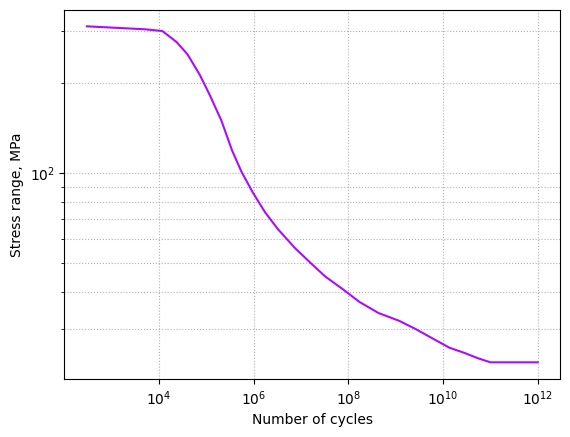

In [3]:
knee_points = """
              1, 321
             10, 320
            300, 310
          1_000, 308
          5_039, 303
         11_771, 299
         23_357, 275
         39_967, 250
         73_176, 213
        119_377, 182
        207_880, 150
        350_376, 119
        553_241, 101
        963_397,  86
      1_733_270,  74
      3_221_789,  65
      7_525_202,  56
     15_937_828,  50
     32_671_572,  45
     73_861_998,  41
    172_521_054,  37
    430_133_471,  34
  1_182_699_719,  32
  2_673_778_988,  30
  5_850_681_784,  28
 13_665_563_053,  26
 28_013_567_611,  25
 53_798_384_034,  24
121_624_268_965,  23
"""

# Convert the string data to a list of lists
knee_points_list = [list(map(float, line.split(',')))
                    for line in knee_points.strip().split('\n')]
knee_points_list = np.array(knee_points_list)

curve_fkp = SNCurve.from_knee_points(
    knee_stress=knee_points_list[:,1],
    knee_cycles=knee_points_list[:,0],
    endurance=1E11,
    norm="Custom",
    curve="From Knee Points",
    environment="Interpolated",
)
curve_fkp.plot()

slope = curve_fkp.slope
intercept = curve_fkp.intercept
endurance = curve_fkp.endurance


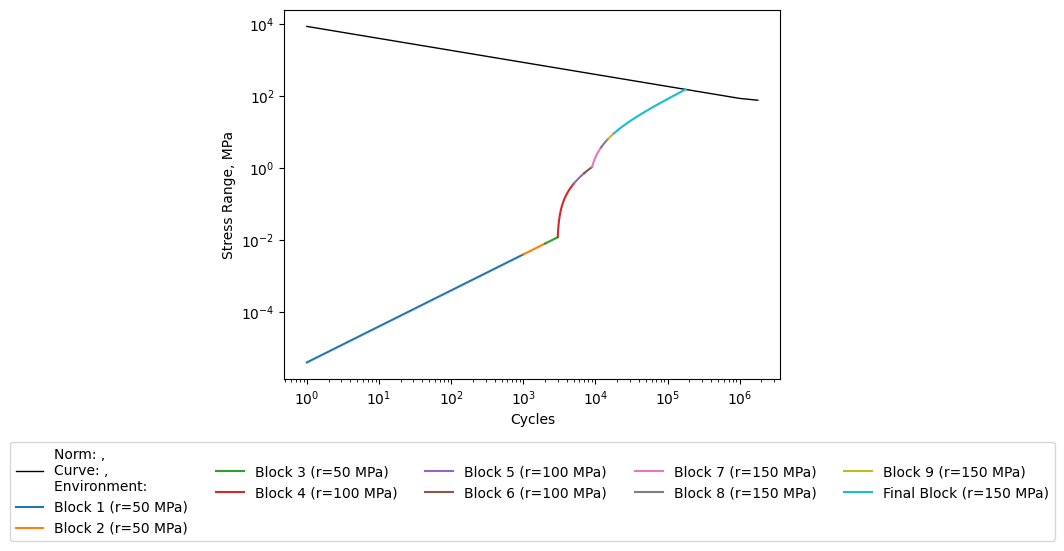

In [4]:
# --- Example usage ---
n_blocks = 3
stress_range = np.array([50, 100, 150])
count_cycle = np.array([1000, 2000, 3000])
# Increase the size of stress_range and count_cycle
stress_range = np.repeat(stress_range, n_blocks)
count_cycle = np.repeat(count_cycle, n_blocks)
slope=np.array([3, 5])
intercept=np.array([11.764, 15.606])
endurance=float("inf")
sn_curve = SNCurve(slope, intercept, endurance)
N_total, history, fig, ax = calc_theil_cycles_to_failure(
    stress_range, count_cycle, sn_curve, plot=True
)
ax.set_yscale("log")


In [5]:
from py_fatigue.damage.stress_life import calc_nonlinear_damage_with_dca

In [7]:
dmg, cumsum_dmg = calc_nonlinear_damage_with_dca(
    "pavlou",
    stress_range,
    count_cycle,
    sn_curve,
    damage_bands=np.linspace(0, 1, 100),
    limit_damage=1
)

In [9]:
cumsum_dmg

array([7.74194393e-05, 1.54838879e-04, 1.93090770e-03, 5.37464485e-03,
       8.81838200e-03, 2.64496985e-02, 4.38836178e-02, 6.13175371e-02,
       7.87514565e-02])

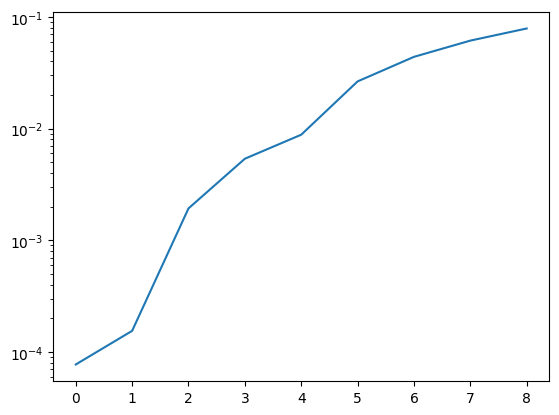

In [10]:
plt.semilogy(cumsum_dmg)

In [ ]:


# --- Basic functions ---

def calc_w(stress_range, sn_curve: SNCurve):
    """
    Calculate the slope of the linearized damage growth curve.
    """
    cycles_to_failure = sn_curve.get_cycles(stress_range)
    return stress_range / cycles_to_failure


def block_stress_range(w, n):
    """
    Compute damage as: f = w * n.
    """
    return w * n


def solve_fatigue_life(a, m, w, b, N_min=1e0, N_max=1e10, tol=1e-6):
    """
    Solve (a / N)^(1/m) = w * N + b for N using bisection.
    """
    bisect_sn_curve_residuals = numba_bisect(sn_curve_residuals, slope=m,
                                             intercept=a, endurance=np.inf,
                                             weight=w, res_stress=b)
    return bisect_sn_curve_residuals(N_min, N_max, tol=tol)

# --- Generalized multi-block predictor with history ---
def predict_multiblock_life_with_history(
    stress_range, count_cycle, sn_curve: SNCurve, num_points=10
):
    """
    For L blocks (with L-1 predetermined blocks and the final block unscheduled),
    compute the total predicted fatigue life along with a history of the piecewise
    linear damage curves.
    
    Parameters:
      a           : Basquin constant.
      m           : Basquin exponent.
      r_list      : Array-like of stress levels for each block (length L).
      N_const_list: Array-like of constant-amplitude lives for each block (length L).
      n_applied   : Array-like of applied cycles in blocks 1..L-1 (length L-1).
      num_points  : Number of points per block segment for plotting.
      
    Returns:
      N_total     : Total predicted fatigue life (cycles) (i.e. end of final block).
      history     : A list of segments; each segment is a tuple (n_segment, f_segment, label)
                    where n_segment and f_segment are arrays of cycles and damage.
    """
    
    history = []
    
    # Start at 0 cycles and 0 stress range
    n_cumsum = 0.0
    stress_range_cumsum = 0.0  # effective stress range at the block end
    
    # Process predetermined blocks (blocks 1 to L-1)
    w = calc_w(stress_range, sn_curve)
    for i in range(len(count_cycle)):
        
        # For the first block, assume zero offset.
        if i == 0:
            current_stress_range = 0.0
        else:
            # For block i, compute offset so that the effective damage carries over:
            current_stress_range = stress_range_cumsum - block_stress_range(w[i], n_cumsum)

        n_start = n_cumsum
        n_end = n_cumsum + count_cycle[i]
        n_segment = np.logspace(np.log10(n_cumsum + 1), np.log10(n_end), num_points)
        stress_range_segment = block_stress_range(w[i], n_segment) + current_stress_range
        label = f"Block {i+1} (r={stress_range[i]} MPa)"
        history.append((n_segment, stress_range_segment, label))
        
        # Update accumulated cycles and stress range for next block:
        n_cumsum = n_end
        stress_range_cumsum = block_stress_range(w[i], n_cumsum) + current_stress_range

        try:
            # Check if the block has failed
            N_total = solve_fatigue_life(sn_curve.intercept,
                                         sn_curve.slope, w[i],
                                         stress_range_cumsum,
                                         N_min=n_cumsum + 1)
        except ValueError as ve:
            if "No zeros found" in str(ve):
                print(f"failure after {n_start} cycles")
                return n_cumsum, history

    # return history
    # Process final block (block L)
    w_final = w[-1]
    # Compute offset for final block:
    stress_range_final = stress_range_cumsum - block_stress_range(w_final, n_cumsum)
    N_total = solve_fatigue_life(
        sn_curve.intercept, sn_curve.slope, w_final, stress_range_final, N_min=n_cumsum + 1
    )
    if not N_total:
        print(f"failure between {n_start} and {n_cumsum} cycles")
        return N_total, history

    n_final = N_total  # Total cycles at end of final block
    
    n_seg_final = np.logspace(np.log10(n_cumsum + 1), np.log10(n_final), num_points)
    print(f"n_seg_final: {n_seg_final}")
    stress_range_seg_final = block_stress_range(w_final, n_seg_final) + stress_range_final
    print(f"stress_range_seg_final: {stress_range_seg_final}")
    label = f"Final Block (r={stress_range[-1]} MPa)"
    history.append((n_seg_final, stress_range_seg_final, label))
    
    return N_total, history


overflow encountered in double_scalars
overflow encountered in double_scalars
invalid value encountered in double_scalars


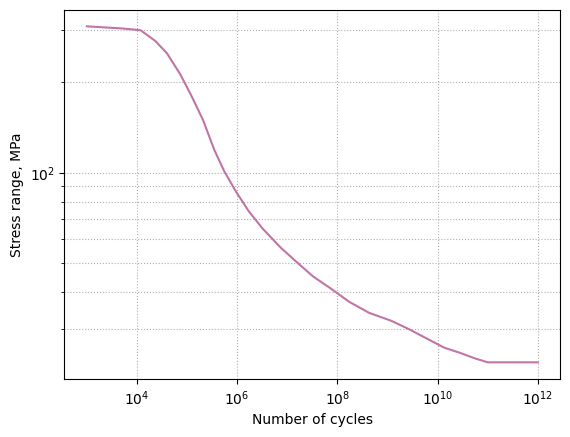

In [31]:
knee_points = """
              1, 321
             10, 320
            100, 315
          1_000, 308
          5_039, 303
         11_771, 299
         23_357, 275
         39_967, 250
         73_176, 213
        119_377, 182
        207_880, 150
        350_376, 119
        553_241, 101
        963_397,  86
      1_733_270,  74
      3_221_789,  65
      7_525_202,  56
     15_937_828,  50
     32_671_572,  45
     73_861_998,  41
    172_521_054,  37
    430_133_471,  34
  1_182_699_719,  32
  2_673_778_988,  30
  5_850_681_784,  28
 13_665_563_053,  26
 28_013_567_611,  25
 53_798_384_034,  24
121_624_268_965,  23
"""

# Convert the string data to a list of lists
knee_points_list = [list(map(float, line.split(',')))
                    for line in knee_points.strip().split('\n')]
knee_points_list = np.array(knee_points_list)

curve_fkp = SNCurve.from_knee_points(
    knee_stress=knee_points_list[:,1],
    knee_cycles=knee_points_list[:,0],
    endurance=1E11,
    norm="Custom",
    curve="From Knee Points",
    environment="Interpolated",
)
curve_fkp.plot()

slope = curve_fkp.slope
intercept = curve_fkp.intercept
endurance = curve_fkp.endurance

overflow encountered in double_scalars
overflow encountered in double_scalars
invalid value encountered in double_scalars


n_seg_final: [  6001.           8906.1915608   13217.83837989  19616.8306334
  29113.68962455  43208.14811499  64125.98635222  95170.52465895
 141244.27987915 209623.16505106]
stress_range_seg_final: [  2.51787576   4.61417524   7.72533082  12.34265253  19.19530237
  29.36544271  44.45913011  66.85994185 100.1053877  149.44554922]


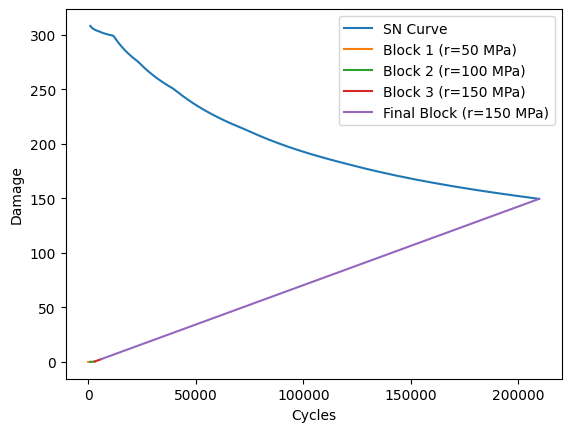

In [33]:
# --- Example usage ---
n_blocks = 3
stress_range = np.array([50, 100, 150])
count_cycle = np.array([1000, 2000, 3000])
# slope=np.array([3, 5])
# intercept=np.array([11.764, 15.606])
# endurance=float("inf")
sn_curve = SNCurve(slope, intercept, endurance)
N_total, history = predict_multiblock_life_with_history(stress_range, count_cycle, sn_curve)
# Plot all the data points alongside with the SN curve

fig, ax = plt.subplots()

cycles = np.logspace(3, np.log10(N_total), 100)
ax.plot(cycles, sn_curve.get_stress(cycles), label="SN Curve")
for n_seg, f_seg, label in history:
    ax.plot(n_seg, f_seg, label=label)
# ax.set_xscale("linear")
ax.set_yscale("linear")
ax.set_xlabel("Cycles")
ax.set_ylabel("Damage")
ax.legend()
plt.show()

In [5]:
history

[(array([   1.        ,    2.15443469,    4.64158883,   10.        ,
           21.5443469 ,   46.41588834,  100.        ,  215.443469  ,
          464.15888336, 1000.        ]),
  array([0.00017219, 0.00037097, 0.00079922, 0.00172187, 0.00370965,
         0.00799221, 0.01721869, 0.03709653, 0.07992206, 0.17218686]),
  'Block 1 (r=100 MPa)'),
 (array([1001.        , 1130.83520233, 1277.51074408, 1443.21090984,
         1630.40329793, 1841.87556772, 2080.77695333, 2350.66516186,
         2655.55935456, 3000.        ]),
  array([0.17494185, 0.53263649, 0.9367261 , 1.39322836, 1.90894146,
         2.49154539, 3.14971625, 3.89325549, 4.73323586, 5.6821663 ]),
  'Block 2 (r=200 MPa)'),
 (array([3001.        , 3241.139252  , 3500.49438549, 3780.60305039,
         4083.12593898, 4409.85663168, 4762.73223081, 5143.84484507,
         5555.45399318, 6000.        ]),
  array([ 5.69611343,  9.04536811, 12.66262929, 16.56934278, 20.78867049,
         25.34562772, 30.2672315 , 35.58266075, 41.323429

In [ ]:

# --- Testing with a K-block load history and plotting ---

# Define a K-block load history.
r_list = np.array([400, 380, 360, 400])       # Stress levels (MPa)
N_const_list = np.array([2496, 4000, 8000, 2496])  # Constant-amplitude lives (cycles)
# Applied cycles in blocks 1 to 3 (block 4 is unscheduled)
n_applied = np.array([799, 500, 1000])
n_blocks = 100
r_list = np.random.randint(50, 150, n_blocks)
N_const_list = np.random.randint(2000, 10000, n_blocks)
n_applied = np.random.randint(500, 1500, n_blocks - 1)

# Basquin parameters: assume m from paper and compute k from block 1:
slope=np.array([3, 5])
intercept=np.array([11.764, 15.606])
endurance=float("inf")
# m = 11.16
# k = r_list[0] * (N_const_list[0] ** (1/m))

# Get predicted fatigue life and history of damage evolution.
N_total, history = predict_multiblock_life_with_history(
    slope, intercept, r_list, N_const_list, n_applied
)

print(f"Total predicted fatigue life (cycles): {N_total}")

# For reference, compute the S/N curve: f_SN = k / N^(1/m)
# We'll plot from n=1 to N_total.
N_vals = np.logspace(0, np.log10(history[-1][0][-1]), 500)
f_SN = k / (N_vals ** (1/m))

# --- Plotting ---
plt.figure(figsize=(10, 6))
# Plot each block's damage evolution segment:
for n_seg, f_seg, label in history:
    plt.plot(n_seg, f_seg, lw=0.5, label=label)

# Plot the S/N curve (constant amplitude curve)
plt.plot(N_vals, f_SN, linewidth=1, label="S/N curve (k/N^(1/m))")

plt.xlabel("Accumulated Cycles (n)")
plt.ylabel("Damage / Stress Level (MPa)")
plt.title("4-Block Load History and S/N Curve\n(Schematic representation similar to Fig. 11)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
solve_fatigue_life(a, m, w, b, N_min=1e0, N_max=1e10, tol=1e-6):

In [ ]:
import types
from scipy.optimize import bisect
import numba as nb

slope=np.array([3, 5])
intercept=np.array([11.764, 15.606])
endurance=float("inf")
weight = 1

#---------------------------------------------------------------------#
# Thank you to Stan Seibert from the Numba team for help with this
#---------------------------------------------------------------------#

@nb.njit(
    # 'float64[::1](float64[::1], float64[::1], float64[::1])',
    fastmath=False,
    parallel=True,
)
def get_stress(cycles, slope, intercept, endurance):
    """
    Calculate the number of cycles to failure for given stress levels.

    Parameters:
    stress (numpy.ndarray): Array of stress values.
    slope (numpy.ndarray): Array of slope values.
    intercept (numpy.ndarray): Array of intercept values.
    endurance (float): Endurance limit.

    Returns:
    numpy.ndarray: Array of calculated cycles to failure.
    """
    assert intercept.size > 0 and intercept.size == slope.size
    assert np.min(cycles) >= 0

    log_cycles = np.log10(cycles)
    log_endurance = np.log10(endurance)
    log_knee_stress = np.empty(intercept.size - 1, dtype=np.float64)
    log_knee_cycles = np.empty(intercept.size - 1, dtype=np.float64)
    if intercept.size > 1:
        for i in nb.prange(intercept.size - 1):  # pylint: disable=E1133
            log_knee_stress[i] = (intercept[i + 1] - intercept[i]) / (
                slope[i + 1] - slope[i]
            )
            log_knee_cycles[i] = intercept[i] - slope[i] * log_knee_stress[i]

    log_knee_stress = np.concatenate(
        (
            np.array([(intercept[0] - 0) / slope[0]]),
            log_knee_stress,
            np.array([(intercept[-1] - log_endurance) / slope[-1]]),
        )
    )
    log_knee_cycles = np.concatenate(
        (np.array([1]), log_knee_cycles, np.array([log_endurance]))
    )
    endurance_stress = 10 ** log_knee_stress[-1]
    idx = np.digitize(log_cycles, log_knee_cycles, right=False) - 1
    the_stress = np.empty(cycles.size, dtype=np.float64)
    nr_knees = intercept.size - 1
    for i in nb.prange(cycles.size):  # pylint: disable=E1133
        if idx[i] <= 0:
            max_i = (intercept[0] - log_cycles[i]) / slope[0]
        elif idx[i] > nr_knees:
            max_i = (log_endurance - log_cycles[i]) / slope[-1]
        else:
            max_i = (intercept[idx[i]] - log_cycles[i]) / slope[idx[i]]
        the_stress[i] = 10**max_i

    if endurance < np.inf:
        the_stress[the_stress < endurance_stress] = endurance_stress
    return the_stress


@nb.njit(
    # 'float64[::1](float64[::1], float64[::1], float64[::1])',
    fastmath=False,
    parallel=True,
)
def root_func(x, slope, intercept, endurance, weight):
    x = np.asarray(x)
    slope = np.asarray(slope)
    intercept = np.asarray(intercept)
    weight = np.asarray(weight)
    assert x.size == weight.size, "x and weight must have the same length"
    return get_stress(x, slope, intercept, endurance) - weight * x


# # def root_func(x, const):
# #     return x**4 - 2*x**2 - x - const


def numba_bisect(f, slope, intercept, endurance, weight):
    """
    Returns a numba-compiled bisection implementation for ``f``.
    """

    def python_bisect(a, b, tol=1E-6, mxiter=1000):
        """
        Bisection method for root finding implemented in Python
        Parameters
        ----------
        a : scalar(int)
            An initial guess
        b : scalar(int)
            An initial guess
        tol : scalar(float)
            The convergence tolerance
        mxiter : scalar(int)
            Max number of iterations to allow
        Note: f(a) should be less than 0 and f(b) should be greater than 0.
              I removed the checks to simplify code.
        """
        assert a > 0 and a < b, "a must be positive and less than b"
        assert tol > 0, "tolerance must be positive"
        assert mxiter > 0, "max iterations must be positive"
        its = 0
        fa = f(np.array([a]), slope, intercept, endurance, weight)
        fb = f(np.array([b]), slope, intercept, endurance, weight)

        if np.abs(fa[0]) < tol:
            return a
        elif np.abs(fb[0]) < tol:
            return b
        c = (a + b) / 2
        fc = f(np.array([c]), slope, intercept, endurance, weight)
        while np.abs(fc[0]) > tol and its < mxiter:

            its += 1

            if fa[0] * fc[0] < 0:
                b = c
                fb = fc
            else:
                a = c
                fa = fc

            c = (a + b) / 2
            fc = f(np.array([c]), slope, intercept, endurance, weight)
        if its == mxiter:
            raise ValueError("No zeros found in the interval provided")
        return c
    return nb.njit()(python_bisect)


#---------------------------------------------------------------------#
#---------------------------------------------------------------------#
jit_bisect_sn_curve_residuals = numba_bisect(
    root_func, slope, intercept, endurance, 1 * weight
)


In [ ]:

print(jit_bisect_root_func(100., 1000000.0))

In [ ]:
print(root_func(np.array([1000]), slope, intercept, endurance, weight))

In [ ]:

def numba_bisect(f, a, b, tol=1e-8, mxiter=500, slope=None, intercept=None, endurance=None, weight=None, *args):
    """
    Wraps this stuff up into a single function
    """
    # if isinstance(f, types.FunctionType):
    jit_bisect_root_func = compile_specialized_bisect(f, slope, intercept, endurance, weight)
    return jit_bisect_root_func(a, b, tol, mxiter)
    # return f(a, b, tol, mxiter)


def python_bisect(f, a, b, tol=1e-8, mxiter=500, *args):
    """
    Beautiful Docstring ...
    Parameters
    ----------
    a : scalar(int)
        An initial guess
    b : scalar(int)
        An initial guess
    tol : scalar(float)
        The convergence tolerance
    mxiter : scalar(int)
        Max number of iterations to allow
    Note: f(a) should be less than 0 and f(b) should be greater than 0.
          I removed the checks to simplify code.
    """
    its = 0
    fa = f(a, *args)
    fb = f(b, *args)

    if abs(fa) < tol:
        return a
    elif abs(fb) < tol:
        return b


    c = (a+b)/2.
    fc = f(c, *args)

    while abs(fc)>tol and its<mxiter:

        its = its + 1

        if fa*fc < 0:
            b = c
            fb = fc

        else:
            a = c
            fa = fc

        c = (a+b)/2.
        fc = f(c, *args)

    return c


jit_bisect_root_func = compile_specialized_bisect(root_func, slope, intercept, endurance, weight)

# print(bisect(root_func, -0.5, 50., args=(slope, intercept, endurance, weight)))
# print(python_bisect(root_func, -0.5, 50., 1e-8, 500, slope[0], intercept[0], endurance, weight))
print(numba_bisect(root_func, np.array([10.]), np.array([10000.]), 1e-8, 500, slope, intercept, endurance, weight))

# print("This is the scipy bisect")
# %timeit bisect(root_func, -.5, 50., args=(CONST,))
# print("This is the python bisect")
%timeit python_bisect(root_func, np.array([10.]), np.array([10000.]), 1e-8, 500, slope, intercept, endurance, weight)
# print("This is the numba bisect")
# %timeit numba_bisect(jit_bisect_root_func, np.array([10.]), np.array([10000.]), 1e-8, 500, slope, intercept, endurance, weight)

In [ ]:
jit_bisect_root_func